# BIA-678: Big Data Technologies

Final Project

6 May 2022

Jarrin Sacayanan

## Introduction
This project is intended to demonstrate the power of distributed computing in machine learning model creation. The work involved in this project will involve developing several supervised learning classification models to classify the polarity of online retail product reviews. To train and test this model, I will utilize an Amazon Reviews dataset with the following properties:
- Records (Rows): 3,600,000 Training & 400,000 Testing
- Attributes (Columns):
  - Review Title
  - Review Body
  - Polarity
  
**Dataset Link**: https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews?select=test.csv

The polarity represented in this dataset is a binary value of **1 (negative)** or **2 (positive)**. The classification model will be trained to perform natural language processing on the review contents to make predictions on the polarity of reviews. Once multiple models have been built and the best selected, I will test the model with reviews of other online retail products and compare it to the accuracy of the testing set.

# Imports and Setup
Before we can begin to build a model, we will need to focus on importing required libraries and loading the data.

**Note**: For those libraries that were not installed by default in Databricks, I used the following command to install them:

`%pip install <package>`

All instances of this have been removed from the Notebook to make it more presentable.

In [0]:
# Library intalls
%pip install nltk

Python interpreter will be restarted.
  Using cached nltk-3.7-py3-none-any.whl (1.5 MB)
  Using cached tqdm-4.64.0-py2.py3-none-any.whl (78 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached regex-2022.4.24-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (764 kB)
Python interpreter will be restarted.


In [0]:
# Basic imports
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# Text cleaning and processing imports
from sklearn.feature_extraction.text import CountVectorizer
from pyspark.sql.functions import countDistinct
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml import PipelineModel

# NLTK imports
import nltk
from nltk.corpus import stopwords

# Other modeling imports
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import NGram, VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark.sql.functions import when 
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import LinearSVC

In [0]:
# Download and define english stopwords
nltk.download('stopwords')
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the Training Set
The main issue with this task was that Databricks did not allow me to upload the complete training set because the file was too large. I wrote a short Python script to split this data on my local machine into 6 separate files and uploaded them to Databricks separately. I then had to combine these files into a single dataset once again.

The Training Set schema is fairly simple:
- **Sentiment Polarity** (Binary Target)
- **Review Title**
- **Review Content**

The lack of attributes/columns will be mitigated by the use of complex natural language in the **Review Content** column. There are **3,600,000** records in total that will be used to train the model.

In [0]:
# Init an empty dataframe from RDD to store the files together
emptyDF = spark.sparkContext.emptyRDD()

# Define the schema of the new dataframe
schema = StructType([
  StructField('label', StringType(), True),
  StructField('title', StringType(), True),
  StructField('review', StringType(), True)
  ])

# Apply the schema to the dataframe
train_df = spark.createDataFrame(emptyDF, schema)

# Load the multiple training set files
for i in range(1,7):
    new_df = spark.read.option("header","true").csv(f'/FileStore/tables/train_{i}.csv') 
    train_df = train_df.union(new_df)

# Show the record count and a preview of the data
print(f'Number of Records: {train_df.count()}')
print(train_df.show())

Number of Records: 3600000
+-----+--------------------+--------------------+
|label|               title|              review|
+-----+--------------------+--------------------+
|    2|Stuning even for ...|This sound track ...|
|    2|The best soundtra...|I'm reading a lot...|
|    2|            Amazing!|"This soundtrack ...|
|    2|Excellent Soundtrack|I truly like this...|
|    2|Remember, Pull Yo...|If you've played ...|
|    2|an absolute maste...|I am quite sure a...|
|    1|        Buyer beware|"This is a self-p...|
|    2|      Glorious story|I loved Whisper o...|
|    2|    A FIVE STAR BOOK|I just finished r...|
|    2|Whispers of the W...|This was a easy t...|
|    1|          The Worst!|A complete waste ...|
|    2|          Great book|This was a great ...|
|    2|          Great Read|I thought this bo...|
|    1|           Oh please|I guess you have ...|
|    1|Awful beyond belief!|"I feel I have to...|
|    1|Don't try to fool...|It's glaringly ob...|
|    2|A romantic zen b

## Load the Test Set
Databricks allowed me to upload the test set with no issues since the file was much smaller. The test set is identical in schema to the training set:
- **Sentiment Polarity** (Binary Target)
- **Review Title**
- **Review Content**

This test set consists of **400,000** records and will be used to test the efficacy of the classification model.

In [0]:
# Load the file directly using the same schema from the training set
test_df = spark.read.format('csv').schema(schema).load('/FileStore/tables/test.csv')

# Show the record count and a preview of the data
print(f'Number of Records: {test_df.count()}')
print(test_df.show())

Number of Records: 400000
+-----+--------------------+--------------------+
|label|               title|              review|
+-----+--------------------+--------------------+
|    2|            Great CD|"My lovely Pat ha...|
|    2|One of the best g...|Despite the fact ...|
|    1|Batteries died wi...|I bought this cha...|
|    2|works fine, but M...|Check out Maha En...|
|    2|Great for the non...|Reviewed quite a ...|
|    1|DVD Player crappe...|I also began havi...|
|    1|      Incorrect Disc|I love the style ...|
|    1|DVD menu select p...|I cannot scroll t...|
|    2|Unique Weird Orie...|"Exotic tales of ...|
|    1|"Not an ""ultimat...|Firstly,I enjoyed...|
|    2|Great book for tr...|I currently live ...|
|    1|                Not!|If you want to li...|
|    1|     A complete Bust|"This game requir...|
|    2|TRULY MADE A DIFF...|I have been using...|
|    1|didn't run off of...|Was hoping that t...|
|    1|          Don't buy!|First of all, the...|
|    2|Simple, Durable, 

# Exploratory Data Analysis and Pre-Processing
Now that the data is loaded, I must perform some exploratory data analysis (EDA) and pre-processing to ensure that the data is ready to use in modeling. Some of the components I will be analyzing include, but are not limited to, the following:
- Missing Data
- Outliers
- Text Uniformity
  - Word Casing (lowering all letter casings)
  - Removing Special Characters

## Removing Null Values
Before performing any modeling, I will need to remove the rows containing null values. First, I will count the null values and then I will remove all rows containing these null values.

In [0]:
# View how many Null values exist in the datasets currently
print('Training Set')
train_df.select([count(when(col(c).isNull(), c)).alias(c) for c in train_df.columns]).show()

print('Test Set')
test_df.select([count(when(col(c).isNull(), c)).alias(c) for c in test_df.columns]).show()

Training Set
+-----+-----+------+
|label|title|review|
+-----+-----+------+
|    0|   77|     7|
+-----+-----+------+

Test Set
+-----+-----+------+
|label|title|review|
+-----+-----+------+
|    0|    4|     1|
+-----+-----+------+



Based on these null counts, I will need to remove some rows from the dataframe. Since the model will be trained using the review body, I will ignore null values in the `Title` column. In other words, the dataset will include reviews without titles.

In [0]:
# Create filtered dataframes to remove the null values
train_df = train_df.filter(train_df['review'].isNotNull())
test_df = test_df.filter(test_df['review'].isNotNull())

In [0]:
# View how many Null values exist in the datasets currently after removing Null values
print('Training Set')
train_df.select([count(when(col(c).isNull(), c)).alias(c) for c in train_df.columns]).show()

print('Test Set')
test_df.select([count(when(col(c).isNull(), c)).alias(c) for c in test_df.columns]).show()

Training Set
+-----+-----+------+
|label|title|review|
+-----+-----+------+
|    0|   77|     0|
+-----+-----+------+

Test Set
+-----+-----+------+
|label|title|review|
+-----+-----+------+
|    0|    4|     0|
+-----+-----+------+



## Checking Data Distribution
Next, I will check the distribution of the data based on the binary classification.

In [0]:
# View he distribution of classifications in the datasets
train_df_pd = train_df.toPandas()
test_df_pd = test_df.toPandas()

print('Train Set Classifications:')
print(train_df_pd['label'].value_counts())

print('Test Set Classifications:')
print(test_df_pd['label'].value_counts())

Train Set Classifications:
1    1799997
2    1799996
Name: label, dtype: int64
Test Set Classifications:
1    200000
2    199999
Name: label, dtype: int64


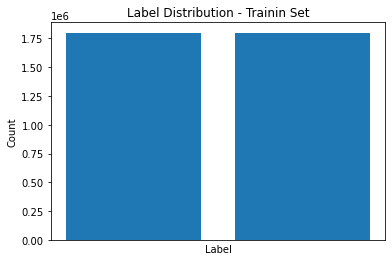

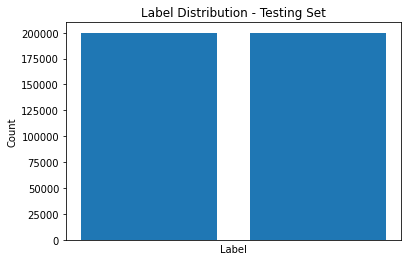

In [0]:
# Visualize the distribution
train_value_counts = train_df_pd['label'].value_counts()
test_value_counts = test_df_pd['label'].value_counts()
value_counts = [train_value_counts, test_value_counts]
labels = ['Trainin Set', 'Testing Set']

# Build bar charts for the value counts
for counts, label in zip(value_counts, labels):
    # Build a bar graph
    plt.bar(counts, max(counts))
    plt.title(f'Label Distribution - {label}')
    plt.xlabel('Label')
    plt.tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)
    plt.ylabel('Count')
    plt.xlim(None)
    plt.show()

Based on the results, there are nearly identical counts for the binary clasification counts in both the training and testing datasets. This shows that the model will have a nearly perfectly balanced dataset to train and test with.

In [0]:
def clean_reviews(review, sw):
    review_list = review.split(' ')
    new_string = ''
    for word in review_list:
        new_string += f'{re.sub("[^a-z]","",word.lower())} '
        
    return new_string

In [0]:
# Standardize the text within the training reviews
clean_reviews = train_df.rdd.map(lambda x: clean_reviews(x['review'], sw)).collect()
    
# Replace the review column in dataframe with new list of clean reviews
tmp_df = train_df_pd.iloc[0: , :-1]
tmp_df['review'] = clean_reviews
tmp_df.head()

# Convert the Pandas dataframe back to Spark dataframe
train_df = spark.createDataFrame(tmp_df)
train_df.show()

+-----+--------------------+--------------------+
|label|               title|              review|
+-----+--------------------+--------------------+
|    2|Stuning even for ...|this sound track ...|
|    2|The best soundtra...|im reading a lot ...|
|    2|            Amazing!|this soundtrack i...|
|    2|Excellent Soundtrack|i truly like this...|
|    2|Remember, Pull Yo...|if youve played t...|
|    2|an absolute maste...|i am quite sure a...|
|    1|        Buyer beware|this is a selfpub...|
|    2|      Glorious story|i loved whisper o...|
|    2|    A FIVE STAR BOOK|i just finished r...|
|    2|Whispers of the W...|this was a easy t...|
|    1|          The Worst!|a complete waste ...|
|    2|          Great book|this was a great ...|
|    2|          Great Read|i thought this bo...|
|    1|           Oh please|i guess you have ...|
|    1|Awful beyond belief!|i feel i have to ...|
|    1|Don't try to fool...|its glaringly obv...|
|    2|A romantic zen ba...|when you hear fol...|


In [0]:
# Standardize the text within the training reviews
clean_reviews = test_df.rdd.map(lambda x: clean_reviews(x['review'], sw)).collect()
    
# Replace the review column in dataframe with new list of clean reviews
tmp_df = test_df_pd.iloc[0: , :-1]
tmp_df['review'] = clean_reviews
tmp_df.head()

# Convert the Pandas dataframe back to Spark dataframe
test_df = spark.createDataFrame(tmp_df)
test_df.show()

In [0]:
# Convert the binary values to 0 and 1
train_df = train_df.withColumn("label", (train_df.label - 1).cast(IntegerType()))
test_df = test_df.withColumn("label", (test_df.label - 1).cast(IntegerType()))

In [0]:
# View a sample of the dataset to ensure labels are correct
train_df.show(15)

+-----+--------------------+--------------------+
|label|               title|              review|
+-----+--------------------+--------------------+
|    1|Stuning even for ...|This sound track ...|
|    1|The best soundtra...|I'm reading a lot...|
|    1|            Amazing!|"This soundtrack ...|
|    1|Excellent Soundtrack|I truly like this...|
|    1|Remember, Pull Yo...|If you've played ...|
|    1|an absolute maste...|I am quite sure a...|
|    0|        Buyer beware|"This is a self-p...|
|    1|      Glorious story|I loved Whisper o...|
|    1|    A FIVE STAR BOOK|I just finished r...|
|    1|Whispers of the W...|This was a easy t...|
|    0|          The Worst!|A complete waste ...|
|    1|          Great book|This was a great ...|
|    1|          Great Read|I thought this bo...|
|    0|           Oh please|I guess you have ...|
|    0|Awful beyond belief!|"I feel I have to...|
+-----+--------------------+--------------------+
only showing top 15 rows



# Building the Models
There will be several steps to building these classification models. To ensure I build a proper model with reasonably accurate predictions, I will test fitting the following models:
- Logistic Regression Classification
- Random Forest
- Support Vector Machine

For this project, I had several potential approaches that included using pre-built sentiment analysis libraries such as TextBlob, Sklearn in Python, or MLLib in PySpark. Given the sheer size of the dataset (4 million records), I decided to use MLLib for distributed compute capabilities. This required me to learn how to use this new set of machine learning libraries to properly build models.

The driving force behind MLLib is the use of defined pipelines. These pipelines perform each step of preprocessing, training, and predicting in the Machine Learning process. For each of the types of models, I will be creating a new pipeline. Each pipeline will include cross validation methods as well as parameter tuning using parameter grids.

Despite using distributed computing techniques, the model training still takes a considerable amount of time (e.g., ~2 hours for Logistic Regression). Each Databricks cluster in the Community Edition is terminated after a short period of non-use, so I will be saving each model using MLLibs `model.save()` function to use/reference on new clusters.

## Creating a Pipeline
Each pipeline will be similar except for the TrainValidationSplit `TVS` function, so the first three units will be declared independently from any model. This includes:
- Tokenizer
- CountVectorizer
- IDF

In [0]:
# Build the pipeline
tokenizer = Tokenizer(inputCol="review", outputCol="words")
cv = CountVectorizer(inputCol="words", outputCol='cv')
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5)

## Decision Tree

In [0]:
# Set up the model
dt = DecisionTreeClassifier()

# Set up the binary classification evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')

# Set up a parameter grid for the model
param_grid = (ParamGridBuilder().addGrid(dt.maxDepth, [2, 5]).build())

In [0]:
# Setup the cross validation
tvs = TrainValidationSplit(estimator=dt, estimatorParamMaps=param_grid, evaluator=evaluator, trainRatio=0.8)

In [0]:
# Build the pipeline
pipeline = Pipeline(stages=[tokenizer, cv, idf, tvs])

# Fit the pipeline
# pipeline_fit = pipeline.fit(train_df)
pipeline_fit = pipeline.fit(temp_df)

In [0]:
pipeline_fit.save(f'/FileStore/tables/dt_pipeline.model')

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-2623649199222819> in <module>
----> 1 pipeline_fit.save(f'/FileStore/tables/dt_pipeline.model')

NameError: name 'pipeline_fit' is not defined

In [0]:
# Make predictions with fitted pipeline
predictions = pipeline_fit.transform(test_df)

In [0]:
# Evaluate the accuracy of the model
accuracy = predictions.filter(predictions["label"] == predictions["prediction"]).count() / float(predictions.count())
print("Accuracy Score: {0:.4f}".format(accuracy))

## Logistic Regression Modeling
The first model I will be using is Logistic Regression classification. This uses the `pyspark.ml.classification.LogisticRegression` library. The pipeline for this model will includes:
1. Tokenizer
2. CountVectorizer
3. InverseDocumentFrequency (IDF)
4. TrainValidationSplit (TVS)

The TVS will consist of:
1. LogisticRegression Model
2. Evaluator
3. Parameter Grid

The pipeline will be trained using the training set and tested by making predictions on the test set. Finally, I will evaluate the results of the model accuracy and save it to disk for future reference.

In [0]:
# Set up the model
lr = LogisticRegression()

# Set up the binary classification evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label', metricName='areaUnderROC')

# Set up a parameter grid for the model
param_grid = (ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).addGrid(lr.fitIntercept, [False, True]).build())

In [0]:
# Setup the cross validation
tvs = TrainValidationSplit(estimator=lr, estimatorParamMaps=param_grid, evaluator=evaluator, trainRatio=0.8)

In [0]:
# Build the pipeline
pipeline = Pipeline(stages=[tokenizer, cv, idf, tvs])

# Fit the pipeline
pipeline_fit = pipeline.fit(train_df)

In [0]:
# Make predictions with fitted pipeline
predictions = pipeline_fit.transform(test_df)

In [0]:
# Evaluate the accuracy of the model
accuracy = predictions.filter(predictions["label"] == predictions["prediction"]).count() / float(predictions.count())
print("Accuracy Score: {0:.4f}".format(accuracy))

Accuracy Score: 0.8748


In [0]:
pipeline_fit.save(f'/FileStore/tables/log_reg_pipeline.model')

## Random Forest Classifier
The second model I will be using is Random Forest classification. This uses the `pyspark.ml.classification.RandomForestClassifier` library. The pipeline for this model will includes:
1. Tokenizer
2. CountVectorizer
3. InverseDocumentFrequency (IDF)
4. TrainValidationSplit (TVS)

The TVS will consist of:
1. LogisticRegression Model
2. Evaluator
3. Parameter Grid

The pipeline will be trained using the training set and tested by making predictions on the test set. Finally, I will evaluate the results of the model accuracy and save it to disk for future reference.

In [0]:
# Set up the model
rf = RandomForestClassifier()

# Set up the binary classification evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')

# Set up a parameter grid for the model
param_grid = (ParamGridBuilder().addGrid(rf.numTrees, [5, 10, 15]).build())

In [0]:
# Setup the cross validation
tvs = TrainValidationSplit(estimator=rf, estimatorParamMaps=param_grid, evaluator=evaluator, trainRatio=0.8)

In [0]:
# Build the pipeline
pipeline = Pipeline(stages=[tokenizer, cv, idf, tvs])

# Fit the pipeline
pipeline_fit = pipeline.fit(df_list[0])

java.net.NoRouteToHostException: No route to host
	at java.base/sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
	at java.base/sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:779)
	at shaded.v9_4.org.eclipse.jetty.io.SelectorManager.doFinishConnect(SelectorManager.java:355)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:232)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.access$1400(ManagedSelector.java:62)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.processSelected(ManagedSelector.java:543)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.produce(ManagedSelector.java:401)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.produceTask(EatWhatYouKill.java:360)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:184)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:171)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:129)
	at shaded.v9_4.org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:367)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:782)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool$Runner.run(QueuedThreadPool.java:914)
	at java.base/java.lang.Thread.run(Thread.java:834)

In [0]:
pipeline_fit.save(f'/FileStore/tables/rf_pipeline.model')

java.net.NoRouteToHostException: No route to host
	at java.base/sun.nio.ch.SocketChannelImpl.checkConnect(Native Method)
	at java.base/sun.nio.ch.SocketChannelImpl.finishConnect(SocketChannelImpl.java:779)
	at shaded.v9_4.org.eclipse.jetty.io.SelectorManager.doFinishConnect(SelectorManager.java:355)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.processConnect(ManagedSelector.java:232)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector.access$1400(ManagedSelector.java:62)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.processSelected(ManagedSelector.java:543)
	at shaded.v9_4.org.eclipse.jetty.io.ManagedSelector$SelectorProducer.produce(ManagedSelector.java:401)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.produceTask(EatWhatYouKill.java:360)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.doProduce(EatWhatYouKill.java:184)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.tryProduce(EatWhatYouKill.java:171)
	at shaded.v9_4.org.eclipse.jetty.util.thread.strategy.EatWhatYouKill.run(EatWhatYouKill.java:129)
	at shaded.v9_4.org.eclipse.jetty.util.thread.ReservedThreadExecutor$ReservedThread.run(ReservedThreadExecutor.java:367)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool.runJob(QueuedThreadPool.java:782)
	at shaded.v9_4.org.eclipse.jetty.util.thread.QueuedThreadPool$Runner.run(QueuedThreadPool.java:914)
	at java.base/java.lang.Thread.run(Thread.java:834)

In [0]:
# Make predictions with fitted pipeline
predictions = pipeline_fit.transform(test_df)

In [0]:
# Evaluate the accuracy of the model
accuracy = predictions.filter(predictions["label"] == predictions["prediction"]).count() / float(predictions.count())
print("Accuracy Score: {0:.4f}".format(accuracy))

In [0]:
pipeline_fit.save(f'/FileStore/tables/rf_pipeline.model')

## SVM

In [0]:
# Set up the model
lsvc = LinearSVC()

# Set up the binary classification evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')

# Set up a parameter grid for the model
param_grid = (ParamGridBuilder().addGrid(lsvc.maxIter, [10, 25, 50]).build())

In [0]:
# Setup the cross validation
tvs = TrainValidationSplit(estimator=lsvc, estimatorParamMaps=param_grid, evaluator=evaluator, trainRatio=0.8)

In [0]:
# Build the pipeline
pipeline = Pipeline(stages=[tokenizer, cv, idf, tvs])

# Fit the pipeline
pipeline_fit = pipeline.fit(train_df)

In [0]:
pipeline_fit.save(f'/FileStore/tables/svm_pipeline.model')

In [0]:
# Make predictions with fitted pipeline
predictions = pipeline_fit.transform(test_df)

In [0]:
# Evaluate the accuracy of the model
accuracy = predictions.filter(predictions["label"] == predictions["prediction"]).count() / float(predictions.count())
print("Accuracy Score: {0:.4f}".format(accuracy))

Accuracy Score: 0.8662


# Modeling Results

In [0]:
# Load the pipelines
svm_pipeline = PipelineModel.load('/FileStore/tables/svm_pipeline.model')
lr_pipeline = PipelineModel.load('/FileStore/tables/log_reg_pipeline.model')

In [0]:
# Get the accuracy for each model
svm_predictions = svm_pipeline.transform(test_df)
lr_predictions = lr_pipeline.transform(test_df)

In [0]:
# Evaluate the accuracy of the models
results_df = pd.DataFrame()

# SVM results
svm_accuracy = svm_predictions.filter(svm_predictions["label"] == svm_predictions["prediction"]).count() / float(svm_predictions.count())
payload = {'Classifier': 'SVM', 'Score': svm_accuracy}
results_df = results_df.append(payload, ignore_index=True)

# Logistic Regression Results
lr_accuracy = lr_predictions.filter(lr_predictions["label"] == lr_predictions["prediction"]).count() / float(lr_predictions.count())
payload = {'Classifier': 'LR', 'Score': lr_accuracy}
results_df = results_df.append(payload, ignore_index=True)

results_df

,Classifier,Score
0,SVM,0.866155
1,LR,0.874825


# Further Model Testing
To evaluate the accuracy of the model, a pre-defined test set was used. To truly evaluate the model, I will use additional reviews originating from other sources. This testing will include:
1. Testing on a set of product reviews scraped from Amazon
2. Testing on a set of sentences defined by user

## Testing with an Amazon Scrape

In [0]:
# Define the schema of the new dataframe
test_schema = StructType([
    StructField('review', StringType(), True),
    StructField('label', IntegerType(), True)
  ])

amazon_df = spark.read.csv('/FileStore/tables/Amazon_Scrape___2022_05_05.csv', header=True)
amazon_df.select([count(when(col(c).isNull(), c)).alias(c) for c in amazon_df.columns]).show()

+------+-----+
|review|label|
+------+-----+
|     0|   10|
+------+-----+



In [0]:
# Filter out the null values
amazon_df = amazon_df.filter(amazon_df['review'].isNotNull())

In [0]:
# Create predictions
prediction = lr_pipeline.transform(amazon_df)
amazon_test_accuracy = prediction.filter(prediction["label"] == prediction["prediction"]).count() / float(prediction.count())
print(amazon_test_accuracy)

0.7272727272727273


## Testing with User Derived Text

In [0]:
# Enter some text that from which sentiment can be easily derived by humans 
new_test_data = pd.DataFrame()
new_review_positive = {'review': 'This product was amazing and I loved the way it worked!'}
new_review_negative = {'review': 'Do not ever buy this product. It did not work at all.'}
new_review_ambiguous = {'review': 'This was the best product if you like trash! I loved how it did not work at all!'}

new_test_data = new_test_data.append(new_review_positive, ignore_index=True)
new_test_data = new_test_data.append(new_review_negative, ignore_index=True)
new_test_data = new_test_data.append(new_review_ambiguous, ignore_index=True)
new_test_data = spark.createDataFrame(new_test_data)
new_test_data.show()

+--------------------+
|              review|
+--------------------+
|This product was ...|
|Do not ever buy t...|
|This was the best...|
+--------------------+



In [0]:
# Make predictions on the user text
prediction = svm_pipeline.transform(new_test_data)
results = prediction.select(['review', 'prediction']).toPandas()

for i, j in zip(results['review'], results['prediction']):
    if j == 1:
        print(f'{i}\nSentiment: Positive\n')
    elif j == 0:
        print(f'{i}\nSentiment: Negative\n')

This product was amazing and I loved the way it worked!
Sentiment: Positive

Do not ever buy this product. It did not work at all.
Sentiment: Negative

This was the best product if you like trash! I loved how it did not work at all!
Sentiment: Negative

